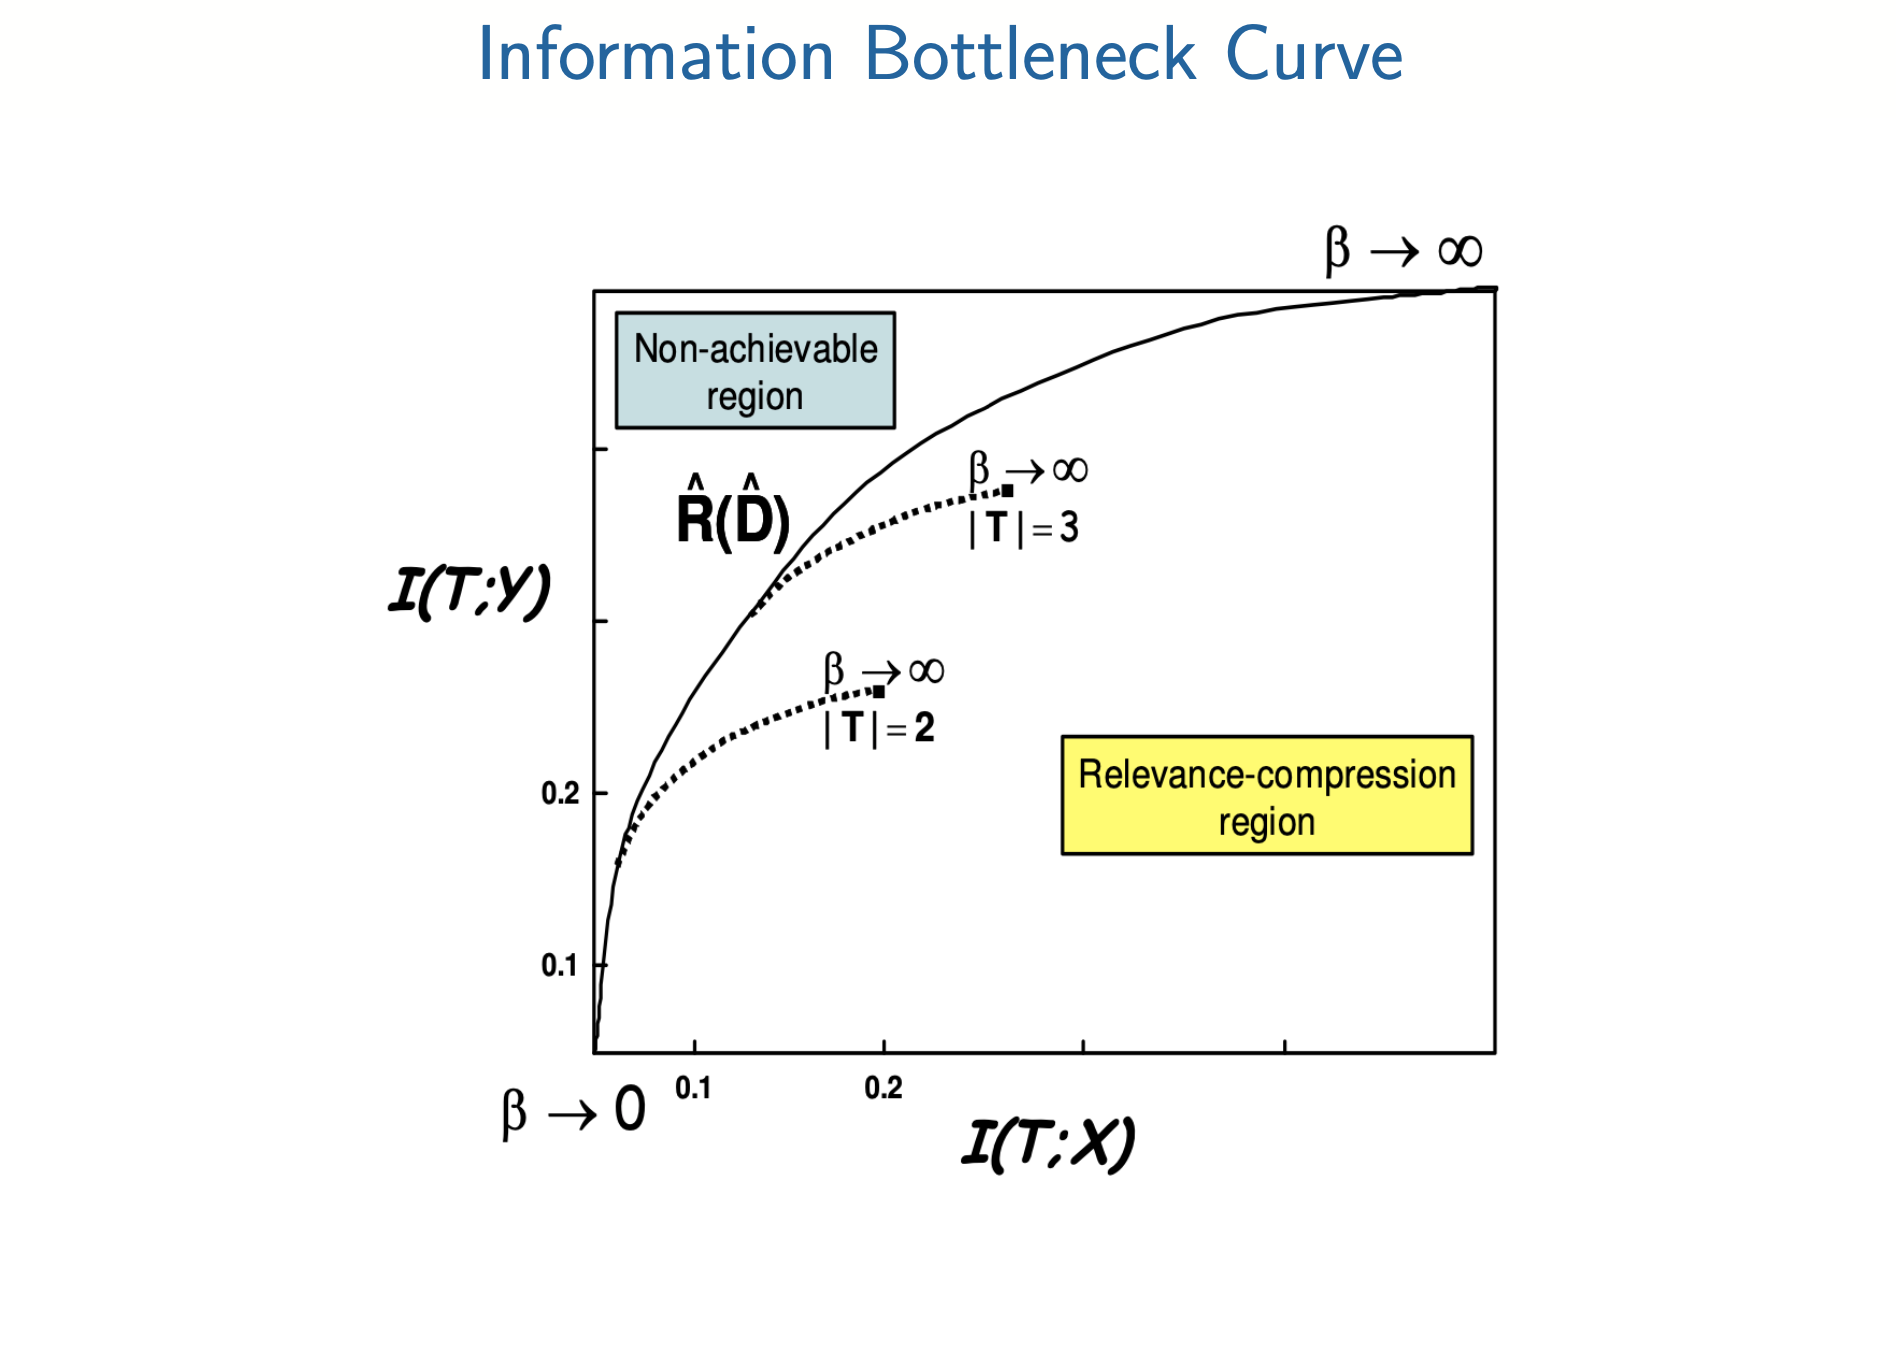

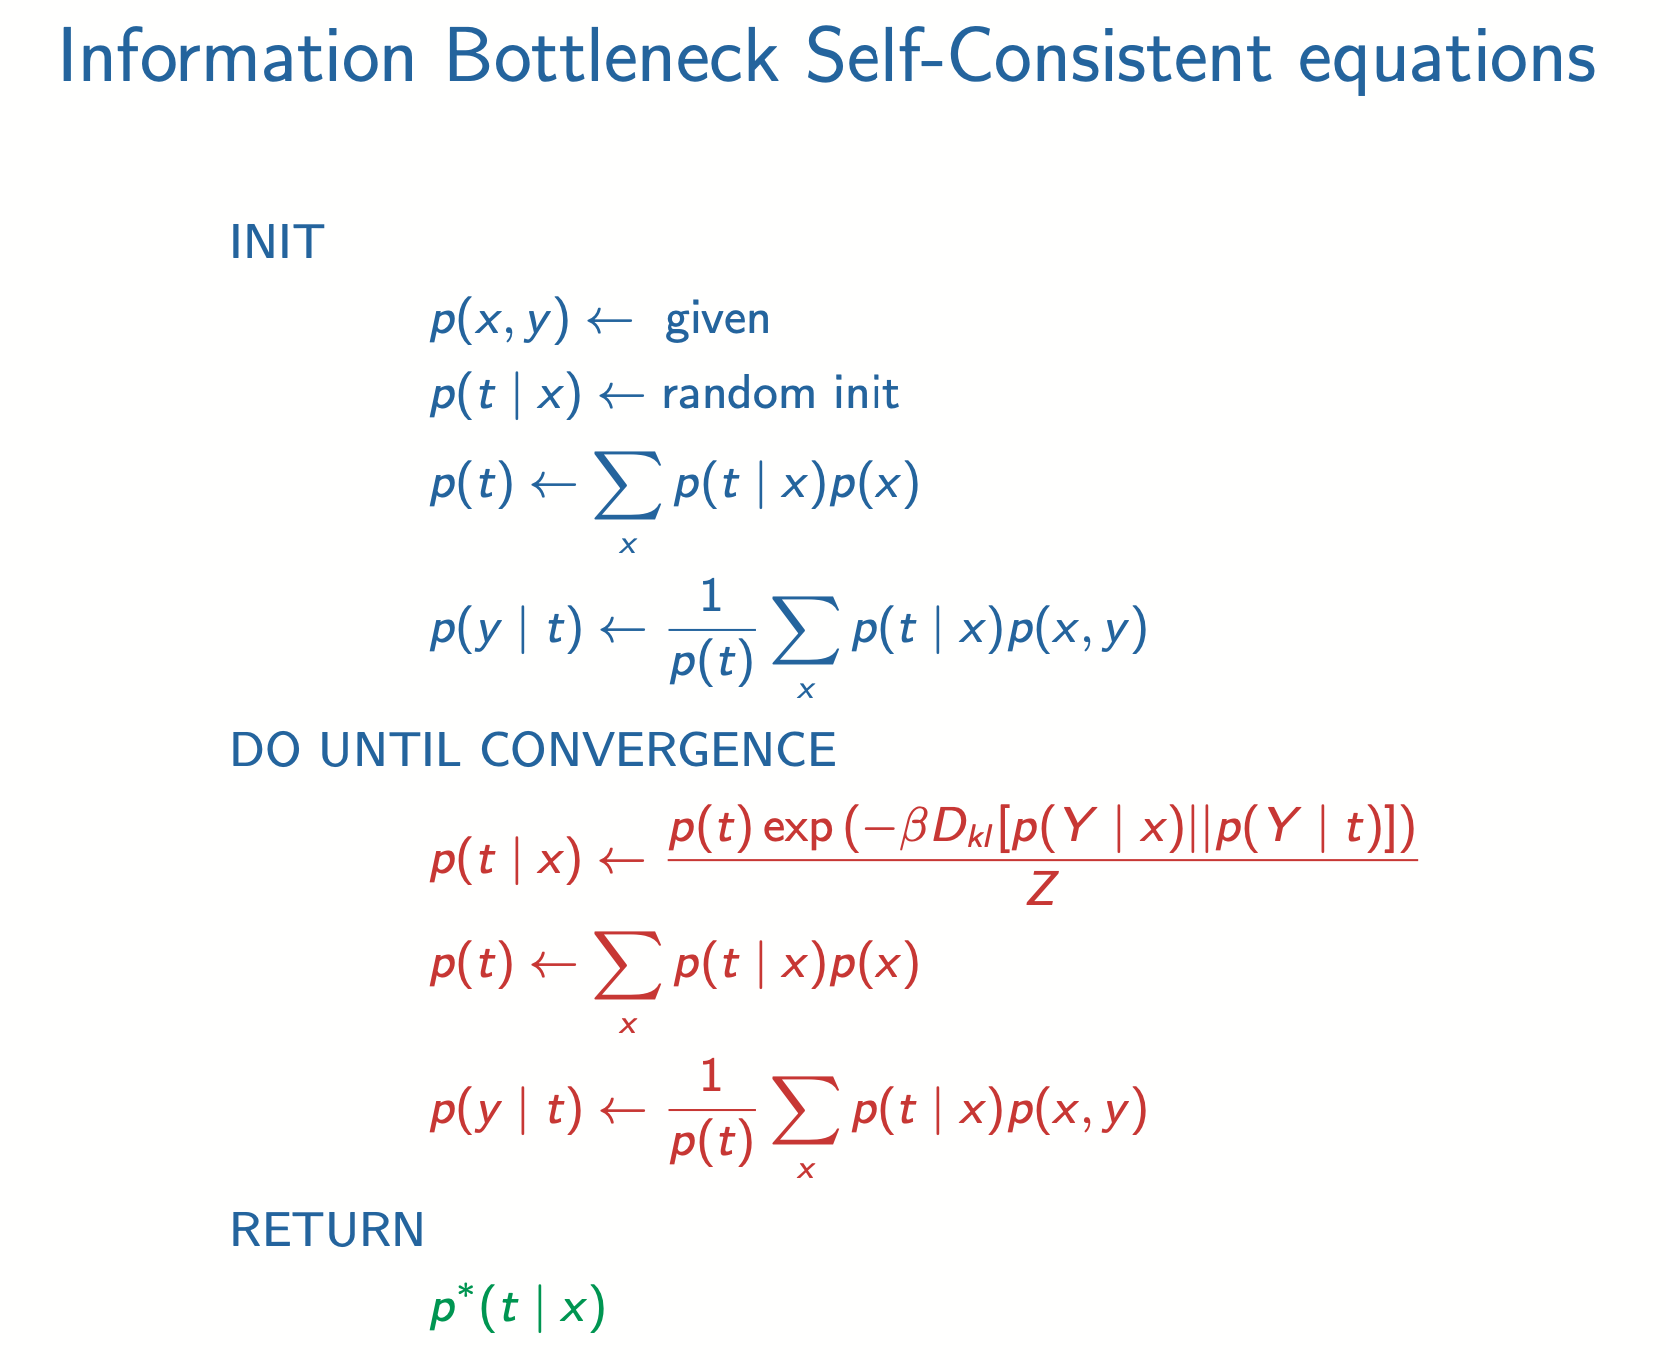

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import math
from scipy.special import rel_entr
from multiprocessing import Pool

In [2]:
def DKL(A, B):
    """
    Kulback-Leibler divergence D(A||B)
    :param A: pa(x), target distribution
    :param B: pb(x), other distribution
    :return: component-wise DKL(pa(x) || pb(x)), which is a tensor of the same dimensionality as A and B
    :        each entry in the tensor is Ai * ln(Ai / Bi), which means the i-th component of DKL.
    :        this code structure, to return the component-wise Dkl, rather than sum_i Ai*ln(Ai/Bi),
    :        simplifies the update equations and the calculation of MI. 
    :        you will use it in the calculation of mutual information and in the update equations of IB.
    """

    # your code
    d = rel_entr(A, B)

    # to avoid numerical issues with too small/large beta, check for inf/nan
    d[np.isnan(d)] = 0 # 1e-64
    d[np.isinf(d)] = 0 # 1e-64
    
    return d

In [3]:
def I(pA, pB, pAB):
    """mutual information I(X,Y) = DKL(P(x,y) || Px x Py)
    :param pA: A - p(a): marginal probability of X
    :param pB: B - p(b): marginal probability of Y
    :param pAB: p(a,b): joint probability of X and Y"""

    
    X = np.sum(DKL(pAB, pA * pB))

    return X

In [4]:
def entropy(p):
    """entropy of a discrete distribution"""
    ### example for the vectorized calculation of the entropy ###
    return -np.sum(p * np.log(p))


In [5]:
def make_probs(*dims):
    XY = np.random.rand(*dims)
    # normalize to a probability
    XY = XY / XY.sum()
    return XY

In [6]:
def compute_for_beta(args):
    beta, pX, pY, pY_X, M, n_tries, n_iters, Xdim = args
    L = np.inf
    I_TX = np.nan
    I_TY = np.nan
    for _ in range(n_tries):
        pTX = make_probs(Xdim, 1, M)
        pT_X = pTX / np.sum(pTX, axis=2, keepdims=True)
        pT = np.sum(pT_X * pX, axis=0)[None]
        pX_T = (pT_X * pX) / (pT + 1e-10)
        temp = pY_X * pX_T[:, None, :]
        pY_T = np.sum(temp, axis=0)[None]
        for _ in range(n_iters):
            DKL_xt = np.sum(rel_entr(pY_X + 1e-10, pY_T + 1e-10), axis=1)[:, None, :]
            exp_term = np.exp(-beta * DKL_xt)
            pT_X_new = pT * exp_term
            Z_x = np.sum(pT_X_new, axis=2, keepdims=True)
            Z_x = np.where(Z_x == 0, 1e-10, Z_x)
            pT_X = pT_X_new / Z_x
            pT = np.sum(pT_X * pX, axis=0)[None]
            pX_T = (pT_X * pX) / (pT + 1e-10)
            temp = pY_X * pX_T[:, None, :]
            pY_T = np.sum(temp, axis=0)[None]
        pTX_joint = pT_X * pX
        I_TX_ = I(pT, pX, pTX_joint)
        pTY_joint = pY_T * pT
        I_TY_ = I(pT, pY, pTY_joint)
        L_ = I_TX_ - beta * I_TY_
        if L_ < L:
            L = L_
            I_TX = I_TX_
            I_TY = I_TY_
    return L, I_TX, I_TY

In [7]:
def iterative_information_bottleneck(
        Xdim, Ydim, Mmax, Mmin,
        n_iters=100,
        n_tries=3,
        n_betas=100,
        beta_min=0.1,
        beta_max=100):
    pXY = make_probs(Xdim, Ydim, 1)
    pX = np.sum(pXY, axis=1, keepdims=True)
    pY = np.sum(pXY, axis=0, keepdims=True)
    pY_X = pXY / pX
    hX = entropy(pX)
    target_MI = I(pX, pY, pXY)
    print("The MI between generated X and Y is:", target_MI)
    print("The entropy of X is:", hX)
    Ls = np.zeros((len(range(Mmax, Mmin-1, -2)), n_betas))
    I_TYs = np.zeros((len(range(Mmax, Mmin-1, -2)), n_betas))
    I_TXs = np.zeros((len(range(Mmax, Mmin-1, -2)), n_betas))
    betas = np.zeros((len(range(Mmax, Mmin-1, -2)), n_betas))
    for m, M in enumerate(range(Mmax, Mmin-1, -2)):
        print(m)
        beta_list = np.linspace(beta_min, beta_max, n_betas)[::-1]
        args_list = [(beta, pX, pY, pY_X, M, n_tries, n_iters, Xdim) for beta in beta_list]
        with Pool() as pool:
            results = pool.map(compute_for_beta, args_list)
        for i, (L, I_TX, I_TY) in enumerate(results):
            Ls[m, i] = L
            I_TXs[m, i] = I_TX
            I_TYs[m, i] = I_TY
            betas[m, i] = beta_list[i]
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].set_title("Lagrangian Temperature Relevance-Compression Curves")
    axs[0].set_xlabel("I(T;X)/H(X)")
    axs[0].set_ylabel("I(T;Y)/I(Y;X)")
    for i, (itx, ity, ls) in enumerate(zip(I_TXs, I_TYs, Ls)):
        axs[0].scatter(itx / hX, ity / target_MI, label=f"M:{Mmax - 2*i}", s=5, c=ls, cmap="plasma")
    axs[1].set_title("Beta Temperature Relevance-Compression Curves")
    axs[1].set_xlabel("I(T;X)/H(X)")
    axs[1].set_ylabel("I(T;Y)/I(Y;X)")
    for i, (itx, ity, bs) in enumerate(zip(I_TXs, I_TYs, betas)):
        axs[1].scatter(itx / hX, ity / target_MI, label=f"M:{Mmax - 2*i}", s=5, c=bs, cmap="RdYlBu_r")
    axs[2].set_title("Relevance-Compression Curves")
    axs[2].set_xlabel("I(T;X)/H(X)")
    axs[2].set_ylabel("I(T;Y)/I(Y;X)")
    for i, (itx, ity) in enumerate(zip(I_TXs, I_TYs)):
        axs[2].scatter(itx / hX, ity / target_MI, label=f"M:{Mmax - 2*i}", s=5)
    axs[2].legend()
    fig.tight_layout()
    plt.show()

In [ ]:
if __name__ == '__main__':
    iterative_information_bottleneck(
        Xdim=10,
        Ydim=5,
        Mmax=10,
        Mmin=1,
        n_iters=100,
        n_tries=5,
        n_betas=1000,
        beta_min=0.1,
        beta_max=1000
    )

The MI between generated X and Y is: 0.18453602803395583
The entropy of X is: 2.2804797113057136
0
